<a href="https://colab.research.google.com/github/GermanOmar/GPs---WAAM/blob/main/GPs_WAAM_PvsWW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process model for Wire + Arc Additive Manufacturing (WAAM) 

<a href="https://ibb.co/WkjFF6k"><img src="https://i.ibb.co/Ycw883c/WAAM1.jpg" WIDTH="500" HEIGHT="300"  border="0"></a>

## Libraries

In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing


## Upload database:

In [44]:
#Experimental data
data = pd.read_table('DATAWAAM.txt') 
data.describe()

,Qp,WW,LH
count,25.000000,25.000000,25.000000
mean,1.421360,7.452800,1.653200
std,0.351795,0.994793,0.215672
min,0.889000,5.800000,1.290000
25%,1.207000,6.700000,1.510000
50%,1.343000,7.350000,1.620000
75%,1.552000,8.000000,1.810000
max,2.298000,9.500000,2.070000


<a href="https://ibb.co/QrLn5c3"><img src="https://i.ibb.co/XS1pw4r/FIG1-geo.png" WIDTH="500" HEIGHT="325"  border="0"></a>

##Setting inputs - output:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


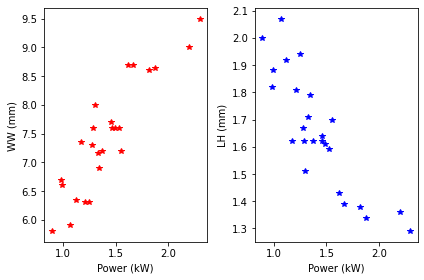

In [45]:
X=data[['Qp']]
Y=data['WW'][:,None]
Z=data['LH'][:,None]

#import seaborn as sns
#sns.set()
fig = plt.figure()

plt.subplot(1, 2, 1)
figsize=(10, 4)
plt.plot(X, Y, 'r*')
plt.xlabel('Power (kW)')
plt.ylabel('WW (mm)')

plt.subplot(1, 2, 2)
plt.plot(X, Z, 'b*')
plt.xlabel('Power (kW)')
plt.ylabel('LH (mm)')

fig.tight_layout()



#Wall Width prediction

## Split data

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=12)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 19  test samples: 6


##Analitical model:

Text(0, 0.5, '$WW (mm)$')

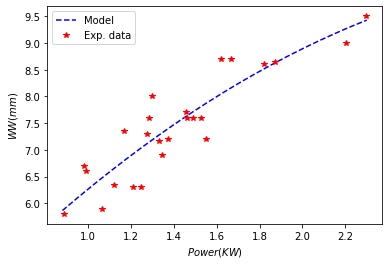

In [47]:
def f(x):
  return -0.6467 * x**2 + 4.5666*x + 2.3454

Xs = np.linspace(0.88,2.3,20)
Ys=f(Xs)
plt.plot(Xs, Ys, 'b--',  label = 'Model')
plt.plot(X, Y, 'r*', label = 'Exp. data')
plt.legend()
plt.xlabel('$Power  (KW)$')
plt.ylabel('$WW (mm)$')

##Gaussian Process

Gaussian Process
MSE train: 0.15370793141655223
MSE test: 0.29143284817538806
MSE train < MSE test? True

R2_train:  0.8008701677148843
R2_test:  0.6928019168636566

Relative error (%):  [[ 4.83965209]
 [ 5.67937785]
 [ 0.93674228]
 [11.97629339]
 [ 0.20561909]
 [ 7.91251978]]


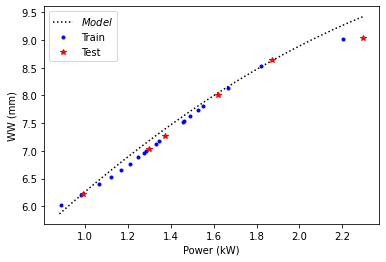

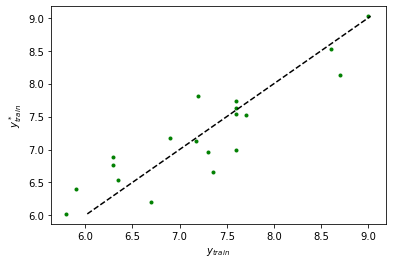

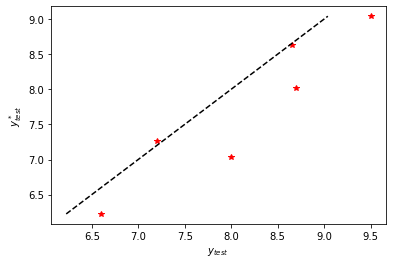

In [24]:
np.random.seed(42)
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
model=GPR(kernel=kernel, n_restarts_optimizer=9, alpha=0.1, normalize_y=True)
 
#Training
model.fit(X_train,y_train)
 
#Testing
y_star_train = model.predict(X_train)
y_pred = model.predict(X_test)
 
#Plots
plt.figure()
plt.plot(Xs, Ys, 'k:', label=r'$Model $')
plt.plot(X_train, y_star_train, 'b.', label='Train')
plt.plot(X_test, y_pred, 'r*', label='Test')
plt.xlabel('Power (kW)')
plt.ylabel('WW (mm)')
plt.legend(loc='upper left')

plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)

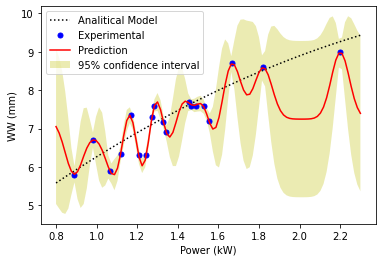

In [30]:
#Tunning hiperparameters (Training data)
np.random.seed(1)

def f(x):
  return -0.6467 * x**2 + 4.5666*x + 2.3454

X = np.asarray(X_train)
y = np.asarray(y_train).ravel()

x = np.atleast_2d(np.linspace(0.8, 2.3, 100)).T

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))
model = GPR(kernel=kernel, n_restarts_optimizer=8, alpha=0.01, normalize_y=True)

model.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = model.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on the MSE
plt.figure()
plt.plot(x, f(x), 'k:', label=r'Analitical Model')
plt.plot(X, y, 'b.', markersize=10, label='Experimental')
plt.plot(x, y_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='y', ec='None', label='95% confidence interval')
plt.xlabel('Power (kW)')
plt.ylabel('WW (mm)')
plt.legend(loc='upper left')


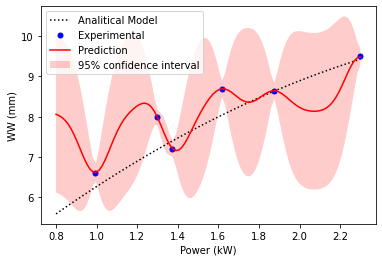

In [31]:
#Tunning hiperparameters (Testing data)
np.random.seed(1234)

def f(x):
  return -0.6467 * x**2 + 4.5666*x + 2.3454

X = np.asarray(X_test)
y = np.asarray(y_test).ravel()

x = np.atleast_2d(np.linspace(0.8, 2.3, 100)).T

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))
model = GPR(kernel=kernel, n_restarts_optimizer=8, alpha=0.01, normalize_y=True)

model.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = model.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on the MSE
plt.figure()
plt.plot(x, f(x), 'k:', label=r'Analitical Model')
plt.plot(X, y, 'b.', markersize=10, label='Experimental')
plt.plot(x, y_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='95% confidence interval')
plt.xlabel('Power (kW)')
plt.ylabel('WW (mm)')
plt.legend(loc='upper left')


#Layer height prediction

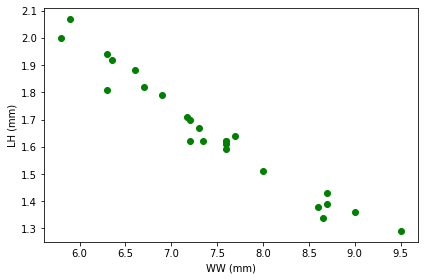

In [27]:
#import seaborn as sns
#sns.set()
fig = plt.figure()
#fig.set_size_inches((6,6))

plt.plot(Y, Z, 'go')
plt.xlabel('WW (mm)')
plt.ylabel('LH (mm)')

plt.tight_layout()

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Y, Z, test_size=0.22, random_state=0)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 19  test samples: 6


Gaussian Process
MSE train: 0.012140259938763389
MSE test: 0.041915664917361824
MSE train < MSE test? True

R2_train:  0.6229992397510896
R2_test:  0.49431503450903946

Relative error (%):  [[ 0.0843072 ]
 [ 5.13094429]
 [21.01987934]
 [ 9.82792799]
 [15.38667083]
 [13.03963046]]


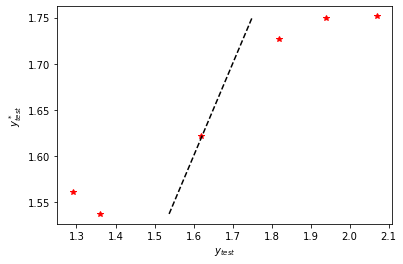

In [41]:
np.random.seed(0)
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
model=GPR(kernel=kernel, n_restarts_optimizer=9, alpha=0.1, normalize_y=True)
 
#Training
model.fit(X_train,y_train)
 
#Testing
y_star_train = model.predict(X_train)
y_pred = model.predict(X_test)
 
plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)

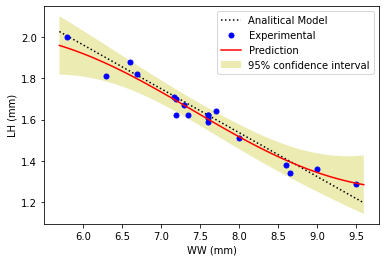

In [36]:
#Tunning hiperparameters (Training data)
np.random.seed(1)

def f(x):
  return -0.2121*x + 3.2343

X = np.asarray(X_train)
y = np.asarray(y_train).ravel()

x = np.atleast_2d(np.linspace(5.7, 9.6, 100)).T

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))
model = GPR(kernel=kernel, n_restarts_optimizer=8, alpha=0.01, normalize_y=True)

model.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = model.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on the MSE
plt.figure()
plt.plot(x, f(x), 'k:', label=r'Analitical Model')
plt.plot(X, y, 'b.', markersize=10, label='Experimental')
plt.plot(x, y_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='y', ec='None', label='95% confidence interval')
plt.xlabel('WW (mm)')
plt.ylabel('LH (mm)')
plt.legend(loc='upper right')


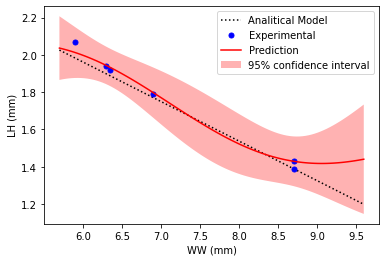

In [39]:
#Tunning hiperparameters (Training data)
np.random.seed(1)

def f(x):
  return -0.2121*x + 3.2343

X = np.asarray(X_test)
y = np.asarray(y_test).ravel()

x = np.atleast_2d(np.linspace(5.7, 9.6, 100)).T

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))
model = GPR(kernel=kernel, n_restarts_optimizer=8, alpha=0.01, normalize_y=True)

model.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = model.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on the MSE
plt.figure()
plt.plot(x, f(x), 'k:', label=r'Analitical Model')
plt.plot(X, y, 'b.', markersize=10, label='Experimental')
plt.plot(x, y_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='r', ec='None', label='95% confidence interval')
plt.xlabel('WW (mm)')
plt.ylabel('LH (mm)')
plt.legend(loc='upper right')
